In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython import display
from tensorflow.keras import datasets
import os
import imageio
import shutil
import time
from PIL import Image
from keras.initializers import RandomNormal, TruncatedNormal
import random
 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D , Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# Define a function to make data usable by a NN and another one to make the generated images in type to be plot
def preprocess(x, size, channels=1):    
    """ Define a function to make data usable by a NN """

    augmented_images = []
    for img in x:
      image = Image.fromarray(img)
      if random.choice([True, False]):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
      augmented_images.append(np.asarray(image))
    
    x = np.asarray(augmented_images).reshape(-1, size, size, channels) 
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    
    return x

def deprocess(x, size, channels): 
    """ Define a function to make the generated images usable by imshow """
    
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    if channels == 1:
      x = x.reshape(size, size)
    else:
      x = x.reshape(size, size, channels)
    return x


def maxlikeloss(y_true, y_pred):
    def inverse_sigmoid(y):
      return tf.math.log(y/(1-y))
    lss = -0.5*tf.math.exp(inverse_sigmoid(y_pred))
    return lss

In [0]:
class GAN():
    
    def __init__(self, name, data):
        
        self.name = name
        self.data = data
        self.val_frac = 0.01

        self.game = "non_saturating"
        
        self.size = 32
        self.channels = 3
        self.batch_size = 128
        self.noise_dim = 100
        
        self.d_learning_rate = 0.001
        self.g_learning_rate = 0.0001
        self.d_beta1 = 0.9
        self.g_beta1 = 0.9
        self.leaky_alpha = 0.2
        
        self.epochs = 10
        self.model_complexity = 7
        self.samples_to_generate = 16
        self.training_time = 0
        self.seed = np.random.normal(0, 1, size=(self.samples_to_generate, self.noise_dim))

        self.losses = {"Train":{"Gen": [], "Disc": []}, "Test":{"Gen": [], "Disc": []}}
        
        self.networks = {"Generator": None, "Discriminator": None}

        # new working directory
        self.main_folder = '/content/GAN_' + str(self.name) + '/'
        if os.path.exists(self.main_folder):
          shutil.rmtree(self.main_folder)
          os.mkdir(self.main_folder)
        else:
          os.mkdir(self.main_folder)


    def set_training_parameters(self, epochs=50, batch_size=128, d_lr=0.001, g_lr=0.0001, d_beta=0.9, g_beta=0.9, alpha=0.2, vf=0.01,
                                size=32, ch=3, noise=100, smpls=16, mdl_cmplx=7, game="non_saturating"):

        self.batch_size = batch_size
        self.d_learning_rate = d_lr
        self.g_learning_rate = g_lr
        self.d_beta1 = d_beta
        self.g_beta1 = g_beta
        self.leaky_alpha = alpha
        self.epochs = epochs
        self.size = size
        self.channels = ch
        self.val_frac = vf
        self.noise_dim = noise
        self.samples_to_generate = smpls
        self.model_complexity = mdl_cmplx
        self.seed = np.random.normal(0, 1, size=(smpls, noise))
        self.game=game


    
    def build_generator(self, summary=False):

        s = self.size//16
        mc = self.model_complexity 

        input_layer = Input((self.noise_dim,))

        hid = Dense(s*s*2**mc, activation='relu')(input_layer)    
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Reshape((s, s, 2**mc))(hid)
        hid = Conv2DTranspose(2**mc, kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2DTranspose(2**(mc-1), kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2DTranspose(2**(mc-2), kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2DTranspose(2**(mc-3), kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2DTranspose(3, kernel_size=5, strides=1, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        out = Activation("tanh")(hid)

        model = Model(inputs=input_layer, outputs=out, name="Generator")

        self.networks["Generator"] = model

        if summary: print(model.summary())
        
        return model
    
    
    def build_discriminator(self, summary=False):
        
        mc = self.model_complexity
        
        input_layer = Input((self.size, self.size, self.channels))

        hid = Conv2D(filters=2**(mc-4), kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(input_layer)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2D(filters=2**(mc-3), kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2D(filters=2**(mc-2), kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2D(filters=2**(mc-1), kernel_size=5, strides=1, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Conv2D(filters=2**mc, kernel_size=5, strides=2, padding="same", kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02))(hid)
        hid = BatchNormalization(momentum=0.9, epsilon=0.00005)(hid)
        hid = LeakyReLU(self.leaky_alpha)(hid)
        hid = Flatten()(hid)
        out = Dense(1, activation="sigmoid")(hid)
        
        model = Model(inputs= input_layer, outputs=out, name="Discriminator")


        self.networks["Discriminator"] = model
        
        if summary: print(model.summary())
        
        return model

    
    def Train(self, progress=False):
        
        x_train, x_test = train_test_split(self.data, test_size=self.val_frac)

        test_size = len(x_test)
        error_seed = self.make_latent_samples(test_size)
        
        x_train_real = preprocess(x_train, self.size, self.channels)
        x_test_real  = preprocess(x_test, self.size, self.channels)
 
        noise_prob = 0.05
        y_train_real = np.zeros((self.batch_size, 1))
        y_train_real[np.random.choice(np.arange(self.batch_size), size=int(noise_prob*self.batch_size))] = 1 
        y_train_fake = np.ones((self.batch_size, 1))
        y_train_fake[np.random.choice(np.arange(self.batch_size), size=int(noise_prob*self.batch_size))] = 0
        y_eval_real  = np.zeros((test_size, 1))
        y_eval_real[np.random.choice(np.arange(test_size), size=int(noise_prob*test_size))]              = 1
        y_eval_fake  = np.ones((test_size, 1))
        y_eval_fake[np.random.choice(np.arange(test_size), size=int(noise_prob*test_size))]              = 0
        

        # Discriminator
        discriminator = self.build_discriminator()
        if self.game in ["minimax", "non_saturating", "max_likelihood"]:
          discriminator.compile(optimizer=Adam(lr=self.d_learning_rate, beta_1=self.d_beta1), loss="binary_crossentropy", metrics=["accuracy"])
        if self.game=="least_squares":
          discriminator.compile(optimizer=Adam(lr=self.d_learning_rate, beta_1=self.d_beta1), loss='mse')
        
        discriminator.trainable=False


        #GAN
        generator = self.build_generator()
        # The discriminator takes generated images as input and determines validity
        gan_input = Input(shape=(self.noise_dim,))
        x = generator(gan_input)
        gan_out = discriminator(x)
        gan = Model(gan_input, gan_out)

        if self.game in ["minimax", "non_saturating"]:
          gan.compile(optimizer=Adam(lr=self.g_learning_rate, beta_1=self.g_beta1), loss="binary_crossentropy")
        if self.game=="least_squares":
          gan.compile(optimizer=Adam(lr=self.g_learning_rate, beta_1=self.g_beta1), loss='mse')
        if self.game=="max_likelihood":
          gan.compile(optimizer=Adam(lr=self.g_learning_rate, beta_1=self.g_beta1), loss=maxlikeloss)

        
    
        start = time.time()

        for epoch in tqdm(range(self.epochs)):

            for i in range(int(x_train_real.shape[0]//self.batch_size)):

                x_batch_real = x_train_real[i*self.batch_size:(i+1)*self.batch_size]

                # latent samples and the generated digit images
                latent_samples = self.make_latent_samples(n=self.batch_size)
                x_batch_fake = generator.predict_on_batch(latent_samples)
                
                # train the discriminator to detect real and fake images
                d_loss_real = discriminator.train_on_batch(x_batch_real, y_train_real * random.uniform(0.9, 1.0))
                d_loss_fake = discriminator.train_on_batch(x_batch_fake, y_train_fake)
                
                # train the generator via GAN
                latent_samples = self.make_latent_samples(n=self.batch_size)
                if self.game=="minimax":
                  g_loss = gan.train_on_batch(latent_samples, y_train_fake)
                if self.game in ["non_saturating", "least_squares", "max_likelihood"]:
                  g_loss = gan.train_on_batch(latent_samples, y_train_real)

                self.losses["Train"]["Disc"].append(0.5*np.add(d_loss_real, d_loss_fake))
                self.losses["Train"]["Gen"].append(g_loss)

                
                
            # evaluate
            x_eval_fake_plot = generator.predict_on_batch(self.seed)
            x_eval_fake = generator.predict_on_batch(error_seed)
 
            d_loss  = discriminator.test_on_batch(x_test_real, y_eval_real)[0]*0.5
            d_loss += discriminator.test_on_batch(x_eval_fake, y_eval_fake)[0]*0.5 # total or average?
            
            if self.game=="minimax":
              g_loss  = gan.test_on_batch(error_seed, y_eval_fake) 
            if self.game in ["non_saturating", "least_squares", "max_likelihood"]:
              g_loss  = gan.test_on_batch(error_seed, y_eval_real) 

                      
                
            self.losses["Test"]["Disc"].append(d_loss)
            self.losses["Test"]["Gen"].append(g_loss)

            
            display.clear_output(wait=True)    
            if progress:
                print("Epoch:{:>3}/{},   Discriminator Loss:{:>7.4f},     Generator Loss:{:>7.4f}".format(epoch+1, self.epochs, d_loss, g_loss))
                self.show_progress(x_eval_fake_plot, epoch)

        self.training_time = time.time() - start
        print('\nTotal training time: ', self.training_time)
            

            
    
    def show_progress(self, generated_images, epoch):

        if os.path.exists(self.main_folder + 'progress_images/'):
          pass
        else: os.mkdir(self.main_folder + 'progress_images/')

        fig = plt.figure(figsize=(10,10))
        fig.suptitle('Epoch:{:4d}'.format(epoch+1), fontsize=15)
        s = len(generated_images)

        rows = 4
        cols = 4

        for i in range(s):
            img = deprocess(generated_images[i], self.size, self.channels)
            plt.subplot(rows, cols, i+1)
            if self.channels == 1:
              plt.imshow(img, cmap='gray')
            else:
              plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(self.main_folder + 'progress_images/image_at_epoch_{:04d}.png'.format(epoch+1))
        plt.show()
        
        return
    
    
    def Plot_losses(self, step="Test"):
        losses = np.array([self.losses[step]['Disc'], self.losses[step]['Gen']])    
    
        fig, ax = plt.subplots()
        plt.plot(losses[0], label='Discriminator', color='blue')
        plt.plot(losses[1], label='Generator', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Training Losses")
        ax.set_ylim(bottom=0)
        plt.legend()
        plt.show()


    def Get_progress_GIF(self):
        
        im_dir = self.main_folder + '/progress_images/'
        images = []

        for file_name in sorted(os.listdir(im_dir)):
          if file_name.endswith('.png'):
            file_path = os.path.join(im_dir, file_name)
            images.append(imageio.imread(file_path))
        
        imageio.mimsave(self.main_folder + 'GAN.gif', images, fps=5)


    def Get_Model(self, key):
        return self.networks[key]
    
    def Save_parameters(self):
        with open(self.main_folder + 'parameters.txt', 'w') as file:
          file.write('Generative Adversarial Network: {}\n'.format(self.name))
          file.write('\n')
          file.write('Data shape: {}\n'.format(self.data.shape))
          file.write('Validation fraction: {}\n'.format(self.val_frac))
          file.write('Dimension of the latent data: {}\n'.format(self.noise_dim))

          file.write('\n' + '----- Discriminator -----\n')
          file.write('Learning rate of the discriminator: {}\n'.format(self.d_learning_rate))
          file.write('Beta parameter of the discriminator: {}\n'.format(self.d_beta1))
          self.networks['Discriminator'].summary(print_fn=lambda x: file.write(x + '\n'))

          file.write('\n' + '----- Generator -----\n')
          file.write('Learning rate of the generator: {}\n'.format(self.g_learning_rate))
          file.write('Beta parameter of the generator: {}\n'.format(self.g_beta1))
          self.networks['Generator'].summary(print_fn=lambda x: file.write(x + '\n'))

          file.write('\n' + '----- Training parameters -----\n')
          file.write('Number of epochs: {}\n'.format(self.epochs))
          file.write('Total training time: {}\n'.format(self.training_time))
          file.write('Model complexity: {}\n'.format(self.model_complexity))
    
    def Save_model(self, key, path):   
        target = path + "/" + key + '.h5'        
        self.networks[key].save(target)
        print(key + " successfully saved")
        return
    
    def Restore_model(self, key, path):
        self.networks[key] = tf.keras.models.load_model(path)
        print(key + " successfully restored")
        return 
    
    def make_latent_samples(self, n=1):
        noise = np.random.normal(0, 1, size=(n, self.noise_dim))
        return noise
    
     

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

#!unzip /content/drive/My\ Drive/Colab\ Notebooks/data/celeb128.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/Colab Notebooks/data/celeb128.zip
replace 100k.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
from glob import glob

#INPUT_DATA_DIR = '/content/cropped/'
#INPUT_DATA_DIR = "/content/100k/100k/"
SIZE = 64

exclude_img_simpsons = ["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
"1702","1281","1272","772","736","737","691","684","314","242","191"]

exclude_img = [s + ".png" for s in exclude_img]

#input_images = np.asarray([np.asarray(Image.open(file).resize((SIZE, SIZE))) for file in glob(INPUT_DATA_DIR + '*') if file not in exclude_img])
input_images = np.asarray([np.asarray(Image.open(file).resize((SIZE, SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

Input: (100000, 64, 64, 3)


In [0]:
DCGAN = GAN(name="TheSimpsons", data=input_images)

In [0]:
# Possible games: minimax, non_saturating, least_squares, max_likelihhod

DCGAN.set_training_parameters(epochs=50, batch_size=128, d_lr=0.00004, g_lr=0.0004, d_beta=0.5, g_beta=0.5, alpha=0.2, vf=0.01,
                                size=SIZE, ch=3, noise=100, smpls=16, mdl_cmplx=9, game="non_saturating")

In [0]:
DCGAN.build_generator(summary=True)
DCGAN.build_discriminator(summary=True)

Epoch: 21/50,   Discriminator Loss: 0.8896,     Generator Loss: 1.5558


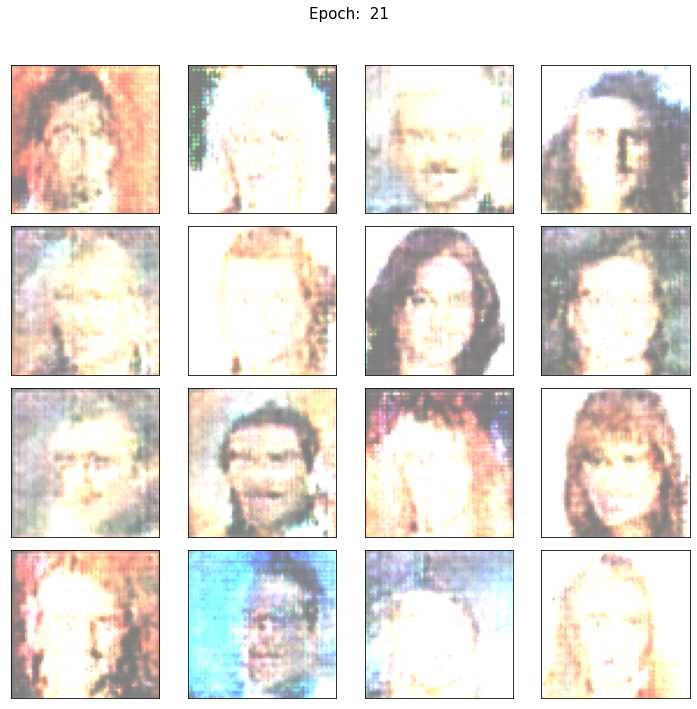

 42%|████▏     | 21/50 [5:31:46<7:37:59, 947.56s/it]

In [0]:
DCGAN.Train(progress=True)

In [0]:
DCGAN.Plot_losses("Training")
DCGAN.Plot_losses("Test")
DCGAN.Save_parameters()

In [0]:
DCGAN.Get_progress_GIF()

In [0]:
# To download the working folder
from google.colab import files
!zip -r /content/GAN.zip /content/GAN_Images/
files.download("/content/GAN.zip")